In [4]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import geopandas as gpd
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow import keras 
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from bandUtils import Band
from convNetUtils import (
    cross_validation,
    spatial_separation_dataset,
    cross_validation_from_csv_files,
)
from visualizationUtils import (
    display_cross_val_map_class,
    plot_confusion_matrix
)

In [3]:
NB_PIXEL_AROUND=4
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()

In [4]:
labels = [
    Label.COFFEE,
    # Label.NATIVEVEGE, now replaced by DENSE_FOREST
    Label.DENSE_FOREST,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

# Spatial validation

In [5]:
DATA_ROOT_PATH = '../data/'
DISTRICTS_PATH = DATA_ROOT_PATH + "districts/diaphantinh.geojson"

In [10]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_february/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND,
    save_on_disk=True,
    dataset_folder_name="Vietnam_2017_january_march"
)

dataset = make_dataset_from_raster_files(**dataset_args)

In [11]:
vietnam_shape = gpd.read_file(DISTRICTS_PATH)

In [12]:
df = pd.DataFrame(dataset, columns=['label', 'images', 'geometry'])
geo_df = gpd.GeoDataFrame(df, geometry='geometry')  # spacv requests a dataframe

In [13]:
geo_df

,label,images,geometry
0,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.26488 14.02468)
1,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.27041 14.02831)
2,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.25905 14.03029)
3,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.26109 14.03121)
4,COFFEE,../data/datasets/images/Vietnam_2017_january_m...,POINT (108.24059 14.02134)
...,...,...,...
9206,TEA,../data/datasets/images/Vietnam_2017_january_m...,POINT (107.76376 11.64308)
9207,TEA,../data/datasets/images/Vietnam_2017_january_m...,POINT (107.76379 11.64391)
9208,TEA,../data/datasets/images/Vietnam_2017_january_m...,POINT (107.76542 11.64458)
9209,TEA,../data/datasets/images/Vietnam_2017_january_m...,POINT (107.76581 11.64659)


In [14]:
geo_df['label']

0       COFFEE
1       COFFEE
2       COFFEE
3       COFFEE
4       COFFEE
         ...  
9206       TEA
9207       TEA
9208       TEA
9209       TEA
9210       TEA
Name: label, Length: 9211, dtype: object

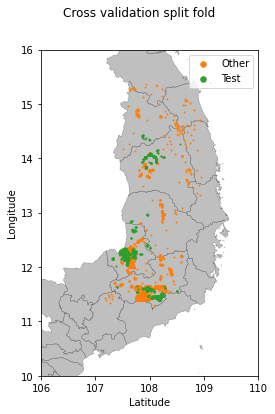

In [15]:
test, other = next(spatial_separation_dataset(geo_df, labels))
display_cross_val_map_class([other, test], vietnam_shape, f"Cross validation split fold")

In [6]:
test_csv_filename = 'Vietnam_2017_january_march_test.csv'
other_csv_filename = 'Vietnam_2017_january_march_other.csv'

In [17]:
# Save test set on the disk
test.to_csv(os.path.join(DATA_ROOT_PATH, 'datasets', test_csv_filename), index=False)

# Save other set on the disk
other.to_csv(os.path.join(DATA_ROOT_PATH, 'datasets', other_csv_filename), index=False)

In [7]:
NB_PIXEL_AROUND=4
NB_TESTS = 4
EPOCHS = 2000

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 3)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 3)           12        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

175/175 [==============================] - 1s 3ms/step - loss: 0.7262 - accuracy: 0.6058 - val_loss: 1.2767 - val_accuracy: 0.5058
Epoch 97/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.7246 - accuracy: 0.6106 - val_loss: 1.3148 - val_accuracy: 0.5386
Epoch 98/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.7254 - accuracy: 0.6017 - val_loss: 1.3596 - val_accuracy: 0.4951
Epoch 99/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.7331 - accuracy: 0.5968 - val_loss: 1.4262 - val_accuracy: 0.4676
Epoch 100/2000
175/175 [==============================] - 1s 4ms/step - loss: 0.7295 - accuracy: 0.5946 - val_loss: 1.1046 - val_accuracy: 0.5368
Epoch 101/2000
175/175 [==============================] - 1s 4ms/step - loss: 0.7343 - accuracy: 0.6069 - val_loss: 1.1254 - val_accuracy: 0.5546
Epoch 102/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.7208 - accuracy: 0.6039 - val_loss: 1.2487 - val_accuracy: 0.5

175/175 [==============================] - 1s 3ms/step - loss: 0.6058 - accuracy: 0.6708 - val_loss: 1.3241 - val_accuracy: 0.5563
Epoch 209/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.6248 - accuracy: 0.6698 - val_loss: 1.2661 - val_accuracy: 0.5812
Epoch 210/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.6175 - accuracy: 0.6616 - val_loss: 1.1603 - val_accuracy: 0.6309
Epoch 211/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.6041 - accuracy: 0.6676 - val_loss: 1.2655 - val_accuracy: 0.5342
Epoch 212/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.6243 - accuracy: 0.6692 - val_loss: 1.3149 - val_accuracy: 0.5022
Epoch 213/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.5904 - accuracy: 0.6735 - val_loss: 1.1638 - val_accuracy: 0.6007
Epoch 214/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.6090 - accuracy: 0.6682 - val_loss: 1.2373 - val_accuracy: 

175/175 [==============================] - 1s 3ms/step - loss: 0.5777 - accuracy: 0.6861 - val_loss: 1.4643 - val_accuracy: 0.5342
Epoch 321/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.5589 - accuracy: 0.6888 - val_loss: 1.4500 - val_accuracy: 0.4969
Epoch 322/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.5974 - accuracy: 0.6900 - val_loss: 1.2334 - val_accuracy: 0.6158
Epoch 323/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.5511 - accuracy: 0.6934 - val_loss: 1.2394 - val_accuracy: 0.6344
Epoch 324/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.5288 - accuracy: 0.6952 - val_loss: 1.2938 - val_accuracy: 0.5909
Epoch 325/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.5371 - accuracy: 0.6963 - val_loss: 1.3400 - val_accuracy: 0.5768
Epoch 326/2000
175/175 [==============================] - 1s 3ms/step - loss: 0.5493 - accuracy: 0.6909 - val_loss: 1.3335 - val_accuracy: 

168/168 [==============================] - 1s 3ms/step - loss: 0.8861 - accuracy: 0.5547 - val_loss: 1.2541 - val_accuracy: 0.4211
Epoch 27/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8711 - accuracy: 0.5700 - val_loss: 1.1566 - val_accuracy: 0.4660
Epoch 28/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8578 - accuracy: 0.5669 - val_loss: 1.1433 - val_accuracy: 0.5146
Epoch 29/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8629 - accuracy: 0.5700 - val_loss: 1.0226 - val_accuracy: 0.5886
Epoch 30/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8710 - accuracy: 0.5669 - val_loss: 1.3372 - val_accuracy: 0.4375
Epoch 31/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8510 - accuracy: 0.5774 - val_loss: 1.1416 - val_accuracy: 0.5176
Epoch 32/2000
168/168 [==============================] - 1s 3ms/step - loss: 0.8595 - accuracy: 0.5667 - val_loss: 1.1884 - val_accuracy: 0.4121

180/180 [==============================] - 1s 3ms/step - loss: 0.9051 - accuracy: 0.5610 - val_loss: 1.5536 - val_accuracy: 0.5089
Epoch 24/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.8867 - accuracy: 0.5717 - val_loss: 1.1316 - val_accuracy: 0.5352
Epoch 25/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.8802 - accuracy: 0.5711 - val_loss: 1.2017 - val_accuracy: 0.5908
Epoch 26/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.8696 - accuracy: 0.5738 - val_loss: 1.6361 - val_accuracy: 0.4659
Epoch 27/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.8758 - accuracy: 0.5802 - val_loss: 1.4852 - val_accuracy: 0.4963
Epoch 28/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.8914 - accuracy: 0.5780 - val_loss: 1.1817 - val_accuracy: 0.5488
Epoch 29/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.8869 - accuracy: 0.5845 - val_loss: 1.1423 - val_accuracy: 0.5876

180/180 [==============================] - 1s 3ms/step - loss: 0.7071 - accuracy: 0.6446 - val_loss: 1.3008 - val_accuracy: 0.5593
Epoch 136/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.6920 - accuracy: 0.6660 - val_loss: 1.1393 - val_accuracy: 0.5782
Epoch 137/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.6685 - accuracy: 0.6553 - val_loss: 1.2924 - val_accuracy: 0.5551
Epoch 138/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.6952 - accuracy: 0.6481 - val_loss: 1.2653 - val_accuracy: 0.5593
Epoch 139/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.6874 - accuracy: 0.6571 - val_loss: 1.2160 - val_accuracy: 0.6002
Epoch 140/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.6839 - accuracy: 0.6662 - val_loss: 1.2414 - val_accuracy: 0.5498
Epoch 141/2000
180/180 [==============================] - 1s 3ms/step - loss: 0.6884 - accuracy: 0.6598 - val_loss: 0.9908 - val_accuracy: 

187/187 [==============================] - 1s 3ms/step - loss: 0.6576 - accuracy: 0.6438 - val_loss: 1.1474 - val_accuracy: 0.5873
Epoch 105/2000
187/187 [==============================] - 1s 3ms/step - loss: 0.6648 - accuracy: 0.6396 - val_loss: 1.0964 - val_accuracy: 0.6310
Epoch 106/2000
187/187 [==============================] - 1s 3ms/step - loss: 0.6435 - accuracy: 0.6540 - val_loss: 1.2257 - val_accuracy: 0.6243
Epoch 107/2000
187/187 [==============================] - 1s 3ms/step - loss: 0.6505 - accuracy: 0.6379 - val_loss: 1.1336 - val_accuracy: 0.6283
Epoch 108/2000
187/187 [==============================] - 1s 3ms/step - loss: 0.6485 - accuracy: 0.6441 - val_loss: 1.2843 - val_accuracy: 0.6071
Epoch 109/2000
187/187 [==============================] - 1s 3ms/step - loss: 0.6600 - accuracy: 0.6399 - val_loss: 1.1949 - val_accuracy: 0.6138
Epoch 110/2000
187/187 [==============================] - 1s 3ms/step - loss: 0.6503 - accuracy: 0.6583 - val_loss: 1.1701 - val_accuracy: 

130/130 [==============================] - 0s 3ms/step - loss: 0.9984 - accuracy: 0.4958 - val_loss: 1.1823 - val_accuracy: 0.5317
Epoch 18/2000
130/130 [==============================] - 0s 3ms/step - loss: 1.0041 - accuracy: 0.4817 - val_loss: 1.2418 - val_accuracy: 0.4002
Epoch 19/2000
130/130 [==============================] - 0s 3ms/step - loss: 0.9863 - accuracy: 0.4872 - val_loss: 1.2750 - val_accuracy: 0.4030
Epoch 20/2000
130/130 [==============================] - 0s 3ms/step - loss: 0.9815 - accuracy: 0.4915 - val_loss: 1.2044 - val_accuracy: 0.4769
Epoch 21/2000
130/130 [==============================] - 0s 3ms/step - loss: 0.9626 - accuracy: 0.4989 - val_loss: 1.3346 - val_accuracy: 0.3890
Epoch 22/2000
130/130 [==============================] - 0s 3ms/step - loss: 0.9670 - accuracy: 0.4948 - val_loss: 1.2190 - val_accuracy: 0.4457
Epoch 23/2000
130/130 [==============================] - 0s 3ms/step - loss: 0.9891 - accuracy: 0.4874 - val_loss: 1.3349 - val_accuracy: 0.3504

130/130 [==============================] - 0s 3ms/step - loss: 0.7530 - accuracy: 0.5871 - val_loss: 1.1173 - val_accuracy: 0.4807
Epoch 130/2000
130/130 [==============================] - 0s 4ms/step - loss: 0.7645 - accuracy: 0.5787 - val_loss: 1.0698 - val_accuracy: 0.5111
Epoch 131/2000
130/130 [==============================] - 0s 3ms/step - loss: 0.7439 - accuracy: 0.5823 - val_loss: 1.1006 - val_accuracy: 0.5084
Epoch 132/2000
130/130 [==============================] - 0s 4ms/step - loss: 0.7318 - accuracy: 0.5943 - val_loss: 1.0320 - val_accuracy: 0.5644
Epoch 133/2000
130/130 [==============================] - 0s 4ms/step - loss: 0.7215 - accuracy: 0.5965 - val_loss: 1.1734 - val_accuracy: 0.4807
Epoch 134/2000
130/130 [==============================] - 0s 3ms/step - loss: 0.7590 - accuracy: 0.5763 - val_loss: 1.2058 - val_accuracy: 0.4947
Epoch 135/2000
130/130 [==============================] - 0s 3ms/step - loss: 0.7374 - accuracy: 0.5811 - val_loss: 1.1555 - val_accuracy: 

/home/simon/miniconda3/envs/earthEngine/lib/python3.7/site-packages/spacv/spacv.py:225: UserWarning: 1 folds contain less than three points and do not form polygons.
  warnings.warn(warn)



Validation 2, fold 1 :
---------------------------

Epoch 1/2000
156/156 [==============================] - 1s 4ms/step - loss: 1.6358 - accuracy: 0.2143 - val_loss: 1.7628 - val_accuracy: 0.1013
Epoch 2/2000
156/156 [==============================] - 1s 3ms/step - loss: 1.4031 - accuracy: 0.3020 - val_loss: 1.7441 - val_accuracy: 0.1053
Epoch 3/2000
156/156 [==============================] - 1s 3ms/step - loss: 1.2539 - accuracy: 0.3236 - val_loss: 1.5801 - val_accuracy: 0.1603
Epoch 4/2000
156/156 [==============================] - 1s 3ms/step - loss: 1.1827 - accuracy: 0.3682 - val_loss: 1.3108 - val_accuracy: 0.4957
Epoch 5/2000
156/156 [==============================] - 1s 3ms/step - loss: 1.1280 - accuracy: 0.3960 - val_loss: 1.6508 - val_accuracy: 0.3400
Epoch 6/2000
156/156 [==============================] - 1s 3ms/step - loss: 1.0924 - accuracy: 0.3932 - val_loss: 1.1511 - val_accuracy: 0.4837
Epoch 7/2000
156/156 [==============================] - 1s 3ms/step - loss: 1.0857 

156/156 [==============================] - 1s 3ms/step - loss: 0.6955 - accuracy: 0.5974 - val_loss: 1.0732 - val_accuracy: 0.5821
Epoch 114/2000
156/156 [==============================] - 1s 3ms/step - loss: 0.7160 - accuracy: 0.5946 - val_loss: 1.1164 - val_accuracy: 0.5839
Epoch 115/2000
156/156 [==============================] - 1s 3ms/step - loss: 0.6960 - accuracy: 0.6004 - val_loss: 0.9479 - val_accuracy: 0.6777
Epoch 116/2000
156/156 [==============================] - 1s 3ms/step - loss: 0.7044 - accuracy: 0.6074 - val_loss: 1.0129 - val_accuracy: 0.6434
Epoch 117/2000
156/156 [==============================] - 1s 3ms/step - loss: 0.6678 - accuracy: 0.6098 - val_loss: 1.2344 - val_accuracy: 0.4980
Epoch 118/2000
156/156 [==============================] - 1s 3ms/step - loss: 0.6890 - accuracy: 0.5956 - val_loss: 1.0577 - val_accuracy: 0.6010
Epoch 119/2000
156/156 [==============================] - 1s 3ms/step - loss: 0.6755 - accuracy: 0.6138 - val_loss: 0.9943 - val_accuracy: 

164/164 [==============================] - 1s 3ms/step - loss: 0.8404 - accuracy: 0.5840 - val_loss: 1.1399 - val_accuracy: 0.4949
Epoch 35/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.8403 - accuracy: 0.5864 - val_loss: 1.1632 - val_accuracy: 0.5481
Epoch 36/2000
164/164 [==============================] - 1s 4ms/step - loss: 0.8488 - accuracy: 0.5792 - val_loss: 1.1617 - val_accuracy: 0.5104
Epoch 37/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.8348 - accuracy: 0.5853 - val_loss: 1.1799 - val_accuracy: 0.4808
Epoch 38/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.8392 - accuracy: 0.5887 - val_loss: 1.3558 - val_accuracy: 0.4997
Epoch 39/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.8277 - accuracy: 0.5910 - val_loss: 1.1912 - val_accuracy: 0.4923
Epoch 40/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.8140 - accuracy: 0.5904 - val_loss: 1.2212 - val_accuracy: 0.4902

164/164 [==============================] - 1s 3ms/step - loss: 0.6583 - accuracy: 0.6486 - val_loss: 1.1311 - val_accuracy: 0.5515
Epoch 147/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.6625 - accuracy: 0.6551 - val_loss: 1.0861 - val_accuracy: 0.6074
Epoch 148/2000
164/164 [==============================] - 1s 4ms/step - loss: 0.6732 - accuracy: 0.6549 - val_loss: 1.2240 - val_accuracy: 0.5407
Epoch 149/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.6444 - accuracy: 0.6535 - val_loss: 1.1805 - val_accuracy: 0.5529
Epoch 150/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.6433 - accuracy: 0.6722 - val_loss: 1.1612 - val_accuracy: 0.5677
Epoch 151/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.6569 - accuracy: 0.6655 - val_loss: 1.1191 - val_accuracy: 0.5771
Epoch 152/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.6502 - accuracy: 0.6547 - val_loss: 1.1347 - val_accuracy: 

164/164 [==============================] - 1s 3ms/step - loss: 0.5597 - accuracy: 0.6929 - val_loss: 1.1165 - val_accuracy: 0.5731
Epoch 259/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5758 - accuracy: 0.6878 - val_loss: 1.1598 - val_accuracy: 0.5657
Epoch 260/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5631 - accuracy: 0.6899 - val_loss: 1.1770 - val_accuracy: 0.5690
Epoch 261/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5848 - accuracy: 0.6910 - val_loss: 1.1615 - val_accuracy: 0.5582
Epoch 262/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5857 - accuracy: 0.6912 - val_loss: 1.2363 - val_accuracy: 0.5475
Epoch 263/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5754 - accuracy: 0.7011 - val_loss: 1.1830 - val_accuracy: 0.5441
Epoch 264/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5795 - accuracy: 0.7072 - val_loss: 1.1708 - val_accuracy: 

164/164 [==============================] - 1s 3ms/step - loss: 0.5035 - accuracy: 0.7243 - val_loss: 1.1293 - val_accuracy: 0.5643
Epoch 371/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.4926 - accuracy: 0.7344 - val_loss: 1.2416 - val_accuracy: 0.5670
Epoch 372/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5070 - accuracy: 0.7180 - val_loss: 1.1557 - val_accuracy: 0.5953
Epoch 373/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5436 - accuracy: 0.7020 - val_loss: 1.1544 - val_accuracy: 0.5939
Epoch 374/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5113 - accuracy: 0.7195 - val_loss: 1.2818 - val_accuracy: 0.5919
Epoch 375/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5389 - accuracy: 0.7020 - val_loss: 1.1020 - val_accuracy: 0.5879
Epoch 376/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.5213 - accuracy: 0.7237 - val_loss: 1.2686 - val_accuracy: 

164/164 [==============================] - 1s 3ms/step - loss: 0.4878 - accuracy: 0.7408 - val_loss: 1.1384 - val_accuracy: 0.5751
Epoch 483/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.4843 - accuracy: 0.7365 - val_loss: 1.2182 - val_accuracy: 0.5596
Epoch 484/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.4652 - accuracy: 0.7370 - val_loss: 1.1677 - val_accuracy: 0.6034
Epoch 485/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.4907 - accuracy: 0.7378 - val_loss: 1.1929 - val_accuracy: 0.5663
Epoch 486/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.4868 - accuracy: 0.7317 - val_loss: 1.0835 - val_accuracy: 0.6296
Epoch 487/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.4735 - accuracy: 0.7473 - val_loss: 1.1247 - val_accuracy: 0.5919
Epoch 488/2000
164/164 [==============================] - 1s 3ms/step - loss: 0.4956 - accuracy: 0.7342 - val_loss: 1.2168 - val_accuracy: 

161/161 [==============================] - 1s 3ms/step - loss: 0.8357 - accuracy: 0.5799 - val_loss: 0.9913 - val_accuracy: 0.5385
Epoch 45/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.8350 - accuracy: 0.5944 - val_loss: 1.1701 - val_accuracy: 0.4748
Epoch 46/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.8293 - accuracy: 0.5940 - val_loss: 1.0290 - val_accuracy: 0.5366
Epoch 47/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.8192 - accuracy: 0.5954 - val_loss: 1.0596 - val_accuracy: 0.5328
Epoch 48/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.8336 - accuracy: 0.5803 - val_loss: 1.2640 - val_accuracy: 0.4433
Epoch 49/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.8361 - accuracy: 0.5921 - val_loss: 1.2539 - val_accuracy: 0.4262
Epoch 50/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.8389 - accuracy: 0.5884 - val_loss: 1.2091 - val_accuracy: 0.4142

161/161 [==============================] - 1s 3ms/step - loss: 0.6647 - accuracy: 0.6656 - val_loss: 1.4609 - val_accuracy: 0.3934
Epoch 157/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.6424 - accuracy: 0.6834 - val_loss: 1.2475 - val_accuracy: 0.4817
Epoch 158/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.6600 - accuracy: 0.6629 - val_loss: 1.1848 - val_accuracy: 0.5277
Epoch 159/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.6566 - accuracy: 0.6716 - val_loss: 1.0613 - val_accuracy: 0.5649
Epoch 160/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.6708 - accuracy: 0.6696 - val_loss: 1.3611 - val_accuracy: 0.4288
Epoch 161/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.6552 - accuracy: 0.6770 - val_loss: 1.2280 - val_accuracy: 0.5158
Epoch 162/2000
161/161 [==============================] - 1s 3ms/step - loss: 0.6505 - accuracy: 0.6702 - val_loss: 1.1941 - val_accuracy: 

183/183 [==============================] - 1s 3ms/step - loss: 0.8305 - accuracy: 0.5734 - val_loss: 0.9506 - val_accuracy: 0.6534
Epoch 41/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.8343 - accuracy: 0.5674 - val_loss: 1.4435 - val_accuracy: 0.4789
Epoch 42/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.8365 - accuracy: 0.5824 - val_loss: 1.2184 - val_accuracy: 0.5735
Epoch 43/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.8233 - accuracy: 0.5785 - val_loss: 1.0070 - val_accuracy: 0.6271
Epoch 44/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.8147 - accuracy: 0.5797 - val_loss: 0.9939 - val_accuracy: 0.6385
Epoch 45/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.8218 - accuracy: 0.5783 - val_loss: 1.2335 - val_accuracy: 0.5701
Epoch 46/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.7978 - accuracy: 0.5925 - val_loss: 1.0042 - val_accuracy: 0.6317

183/183 [==============================] - 1s 4ms/step - loss: 0.6536 - accuracy: 0.6644 - val_loss: 0.8324 - val_accuracy: 0.6773
Epoch 153/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6432 - accuracy: 0.6635 - val_loss: 0.9655 - val_accuracy: 0.6442
Epoch 154/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6462 - accuracy: 0.6687 - val_loss: 0.9676 - val_accuracy: 0.6477
Epoch 155/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6314 - accuracy: 0.6768 - val_loss: 1.0161 - val_accuracy: 0.6522
Epoch 156/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6482 - accuracy: 0.6670 - val_loss: 0.9454 - val_accuracy: 0.6431
Epoch 157/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6501 - accuracy: 0.6620 - val_loss: 1.1230 - val_accuracy: 0.6226
Epoch 158/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6241 - accuracy: 0.6712 - val_loss: 0.9590 - val_accuracy: 

183/183 [==============================] - 1s 4ms/step - loss: 0.5684 - accuracy: 0.6888 - val_loss: 1.0591 - val_accuracy: 0.6271
Epoch 265/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5714 - accuracy: 0.7055 - val_loss: 1.0011 - val_accuracy: 0.6306
Epoch 266/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5678 - accuracy: 0.6993 - val_loss: 0.9595 - val_accuracy: 0.6591
Epoch 267/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5850 - accuracy: 0.6930 - val_loss: 0.9735 - val_accuracy: 0.6739
Epoch 268/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5889 - accuracy: 0.6910 - val_loss: 1.0130 - val_accuracy: 0.6363
Epoch 269/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5972 - accuracy: 0.6944 - val_loss: 0.8588 - val_accuracy: 0.6796
Epoch 270/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5694 - accuracy: 0.6990 - val_loss: 1.0337 - val_accuracy: 

177/177 [==============================] - 1s 4ms/step - loss: 0.8718 - accuracy: 0.5238 - val_loss: 1.2491 - val_accuracy: 0.5138
Epoch 22/2000
177/177 [==============================] - 1s 4ms/step - loss: 0.8473 - accuracy: 0.5329 - val_loss: 1.2441 - val_accuracy: 0.5281
Epoch 23/2000
177/177 [==============================] - 1s 4ms/step - loss: 0.8836 - accuracy: 0.5224 - val_loss: 1.3128 - val_accuracy: 0.6072
Epoch 24/2000
177/177 [==============================] - 1s 4ms/step - loss: 0.8568 - accuracy: 0.5313 - val_loss: 1.2259 - val_accuracy: 0.5672
Epoch 25/2000
177/177 [==============================] - 1s 4ms/step - loss: 0.8673 - accuracy: 0.5475 - val_loss: 1.1787 - val_accuracy: 0.5872
Epoch 26/2000
177/177 [==============================] - 1s 4ms/step - loss: 0.8412 - accuracy: 0.5392 - val_loss: 1.3617 - val_accuracy: 0.4795
Epoch 27/2000
177/177 [==============================] - 1s 4ms/step - loss: 0.8355 - accuracy: 0.5445 - val_loss: 1.1637 - val_accuracy: 0.5996

177/177 [==============================] - 1s 3ms/step - loss: 0.6454 - accuracy: 0.6244 - val_loss: 1.4522 - val_accuracy: 0.5443
Epoch 134/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6473 - accuracy: 0.6365 - val_loss: 1.3614 - val_accuracy: 0.5710
Epoch 135/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6351 - accuracy: 0.6360 - val_loss: 1.3902 - val_accuracy: 0.5920
Epoch 136/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6597 - accuracy: 0.6323 - val_loss: 1.4095 - val_accuracy: 0.5615

Validation 3, fold 1 :
---------------------------

Epoch 1/2000
177/177 [==============================] - 1s 4ms/step - loss: 1.6394 - accuracy: 0.1970 - val_loss: 1.8633 - val_accuracy: 0.0741
Epoch 2/2000
177/177 [==============================] - 1s 3ms/step - loss: 1.3191 - accuracy: 0.3233 - val_loss: 1.8305 - val_accuracy: 0.0926
Epoch 3/2000
177/177 [==============================] - 1s 3ms/step - loss: 1.1877 - accur

177/177 [==============================] - 1s 3ms/step - loss: 0.6766 - accuracy: 0.6688 - val_loss: 1.7857 - val_accuracy: 0.4000
Epoch 110/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6800 - accuracy: 0.6695 - val_loss: 1.7513 - val_accuracy: 0.4157
Epoch 111/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6679 - accuracy: 0.6716 - val_loss: 1.4354 - val_accuracy: 0.5426
Epoch 112/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6895 - accuracy: 0.6663 - val_loss: 1.6472 - val_accuracy: 0.5074
Epoch 113/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6796 - accuracy: 0.6668 - val_loss: 1.8330 - val_accuracy: 0.4269
Epoch 114/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6689 - accuracy: 0.6841 - val_loss: 1.6450 - val_accuracy: 0.4343
Epoch 115/2000
177/177 [==============================] - 1s 3ms/step - loss: 0.6563 - accuracy: 0.6713 - val_loss: 1.8098 - val_accuracy: 

183/183 [==============================] - 1s 4ms/step - loss: 0.8750 - accuracy: 0.5434 - val_loss: 1.3714 - val_accuracy: 0.4333
Epoch 25/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.8674 - accuracy: 0.5516 - val_loss: 1.1996 - val_accuracy: 0.5126
Epoch 26/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.8862 - accuracy: 0.5509 - val_loss: 1.1203 - val_accuracy: 0.5379
Epoch 27/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.8803 - accuracy: 0.5570 - val_loss: 1.5429 - val_accuracy: 0.3667
Epoch 28/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.8572 - accuracy: 0.5518 - val_loss: 1.3599 - val_accuracy: 0.4747
Epoch 29/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.8748 - accuracy: 0.5490 - val_loss: 1.4662 - val_accuracy: 0.4230
Epoch 30/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.8542 - accuracy: 0.5555 - val_loss: 1.3190 - val_accuracy: 0.4425

183/183 [==============================] - 1s 3ms/step - loss: 0.6750 - accuracy: 0.6296 - val_loss: 1.0955 - val_accuracy: 0.6287
Epoch 137/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6778 - accuracy: 0.6309 - val_loss: 1.0394 - val_accuracy: 0.6391
Epoch 138/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6904 - accuracy: 0.6285 - val_loss: 1.0782 - val_accuracy: 0.6253
Epoch 139/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6834 - accuracy: 0.6391 - val_loss: 1.1213 - val_accuracy: 0.5851
Epoch 140/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6753 - accuracy: 0.6442 - val_loss: 1.0292 - val_accuracy: 0.6230
Epoch 141/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6673 - accuracy: 0.6425 - val_loss: 1.0122 - val_accuracy: 0.6368
Epoch 142/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6806 - accuracy: 0.6321 - val_loss: 1.2923 - val_accuracy: 

183/183 [==============================] - 1s 3ms/step - loss: 0.6143 - accuracy: 0.6721 - val_loss: 1.1907 - val_accuracy: 0.5460
Epoch 249/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6381 - accuracy: 0.6609 - val_loss: 1.0929 - val_accuracy: 0.5989
Epoch 250/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6046 - accuracy: 0.6708 - val_loss: 1.1938 - val_accuracy: 0.5471
Epoch 251/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6075 - accuracy: 0.6718 - val_loss: 1.0005 - val_accuracy: 0.6103
Epoch 252/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5921 - accuracy: 0.6716 - val_loss: 0.9466 - val_accuracy: 0.6402
Epoch 253/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5992 - accuracy: 0.6743 - val_loss: 0.8856 - val_accuracy: 0.6770
Epoch 254/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.6044 - accuracy: 0.6701 - val_loss: 1.0565 - val_accuracy: 

183/183 [==============================] - 1s 3ms/step - loss: 0.5524 - accuracy: 0.6878 - val_loss: 0.9464 - val_accuracy: 0.6701
Epoch 361/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5565 - accuracy: 0.6878 - val_loss: 0.9365 - val_accuracy: 0.6517
Epoch 362/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5520 - accuracy: 0.6883 - val_loss: 0.9673 - val_accuracy: 0.6759
Epoch 363/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5515 - accuracy: 0.7019 - val_loss: 1.0310 - val_accuracy: 0.6736
Epoch 364/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5582 - accuracy: 0.6900 - val_loss: 1.1459 - val_accuracy: 0.6299
Epoch 365/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5471 - accuracy: 0.7094 - val_loss: 1.0105 - val_accuracy: 0.6678
Epoch 366/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5607 - accuracy: 0.6944 - val_loss: 1.1035 - val_accuracy: 

157/157 [==============================] - 1s 4ms/step - loss: 0.9099 - accuracy: 0.5300 - val_loss: 1.2525 - val_accuracy: 0.4673
Epoch 19/2000
157/157 [==============================] - 1s 3ms/step - loss: 0.9064 - accuracy: 0.5312 - val_loss: 1.0718 - val_accuracy: 0.5657
Epoch 20/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.9006 - accuracy: 0.5399 - val_loss: 1.1275 - val_accuracy: 0.5374
Epoch 21/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.8725 - accuracy: 0.5373 - val_loss: 1.2102 - val_accuracy: 0.4867
Epoch 22/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.8840 - accuracy: 0.5516 - val_loss: 1.3104 - val_accuracy: 0.4626
Epoch 23/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.8819 - accuracy: 0.5477 - val_loss: 1.0154 - val_accuracy: 0.5763
Epoch 24/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.8588 - accuracy: 0.5651 - val_loss: 1.1832 - val_accuracy: 0.5227

157/157 [==============================] - 1s 4ms/step - loss: 0.6461 - accuracy: 0.6657 - val_loss: 1.0957 - val_accuracy: 0.5645
Epoch 131/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.6434 - accuracy: 0.6552 - val_loss: 1.1174 - val_accuracy: 0.5946
Epoch 132/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.6458 - accuracy: 0.6590 - val_loss: 1.1295 - val_accuracy: 0.5510
Epoch 133/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.6338 - accuracy: 0.6640 - val_loss: 1.1327 - val_accuracy: 0.5439
Epoch 134/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.6415 - accuracy: 0.6729 - val_loss: 1.0525 - val_accuracy: 0.6341
Epoch 135/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.6243 - accuracy: 0.6651 - val_loss: 1.1146 - val_accuracy: 0.6052
Epoch 136/2000
157/157 [==============================] - 1s 4ms/step - loss: 0.6463 - accuracy: 0.6675 - val_loss: 0.9586 - val_accuracy: 

165/165 [==============================] - 1s 4ms/step - loss: 0.8456 - accuracy: 0.5307 - val_loss: 1.2507 - val_accuracy: 0.4790
Epoch 25/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.8391 - accuracy: 0.5541 - val_loss: 1.2442 - val_accuracy: 0.5169
Epoch 26/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.8377 - accuracy: 0.5264 - val_loss: 1.1157 - val_accuracy: 0.5354
Epoch 27/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.8204 - accuracy: 0.5354 - val_loss: 1.1092 - val_accuracy: 0.5719
Epoch 28/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.8090 - accuracy: 0.5628 - val_loss: 1.2885 - val_accuracy: 0.4783
Epoch 29/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.8150 - accuracy: 0.5562 - val_loss: 1.2004 - val_accuracy: 0.4584
Epoch 30/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.8246 - accuracy: 0.5421 - val_loss: 1.1154 - val_accuracy: 0.5320

165/165 [==============================] - 1s 4ms/step - loss: 0.6241 - accuracy: 0.6555 - val_loss: 1.1634 - val_accuracy: 0.5760
Epoch 137/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.5942 - accuracy: 0.6598 - val_loss: 1.3263 - val_accuracy: 0.5416
Epoch 138/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.5997 - accuracy: 0.6585 - val_loss: 1.2428 - val_accuracy: 0.5692
Epoch 139/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.6024 - accuracy: 0.6545 - val_loss: 1.1334 - val_accuracy: 0.6008
Epoch 140/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.6057 - accuracy: 0.6547 - val_loss: 1.2440 - val_accuracy: 0.5492
Epoch 141/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.6069 - accuracy: 0.6524 - val_loss: 1.3956 - val_accuracy: 0.4948
Epoch 142/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.5969 - accuracy: 0.6711 - val_loss: 1.1913 - val_accuracy: 

165/165 [==============================] - 1s 4ms/step - loss: 0.5133 - accuracy: 0.7027 - val_loss: 1.2728 - val_accuracy: 0.5926
Epoch 249/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.4926 - accuracy: 0.7110 - val_loss: 1.5532 - val_accuracy: 0.4990
Epoch 250/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.5076 - accuracy: 0.7086 - val_loss: 1.3405 - val_accuracy: 0.5877
Epoch 251/2000
165/165 [==============================] - 1s 5ms/step - loss: 0.5224 - accuracy: 0.7069 - val_loss: 1.4253 - val_accuracy: 0.5719
Epoch 252/2000
165/165 [==============================] - 1s 5ms/step - loss: 0.5301 - accuracy: 0.6987 - val_loss: 1.3430 - val_accuracy: 0.5451
Epoch 253/2000
165/165 [==============================] - 1s 6ms/step - loss: 0.5176 - accuracy: 0.7033 - val_loss: 1.4053 - val_accuracy: 0.5712
Epoch 254/2000
165/165 [==============================] - 1s 5ms/step - loss: 0.5395 - accuracy: 0.7093 - val_loss: 1.4596 - val_accuracy: 

165/165 [==============================] - 1s 4ms/step - loss: 0.4489 - accuracy: 0.7288 - val_loss: 1.5496 - val_accuracy: 0.5726
Epoch 361/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.4640 - accuracy: 0.7254 - val_loss: 1.6381 - val_accuracy: 0.5540
Epoch 362/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.4729 - accuracy: 0.7197 - val_loss: 1.4323 - val_accuracy: 0.5692
Epoch 363/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.4657 - accuracy: 0.7212 - val_loss: 1.5365 - val_accuracy: 0.5444
Epoch 364/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.4745 - accuracy: 0.7312 - val_loss: 1.4922 - val_accuracy: 0.5602
Epoch 365/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.4738 - accuracy: 0.7229 - val_loss: 1.4265 - val_accuracy: 0.6091
Epoch 366/2000
165/165 [==============================] - 1s 4ms/step - loss: 0.4675 - accuracy: 0.7311 - val_loss: 1.3102 - val_accuracy: 

159/159 [==============================] - 1s 4ms/step - loss: 0.9094 - accuracy: 0.5178 - val_loss: 0.9129 - val_accuracy: 0.6004
Epoch 50/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.8932 - accuracy: 0.5292 - val_loss: 1.0738 - val_accuracy: 0.5505
Epoch 51/2000
159/159 [==============================] - 1s 6ms/step - loss: 0.8755 - accuracy: 0.5531 - val_loss: 1.0208 - val_accuracy: 0.5030
Epoch 52/2000
159/159 [==============================] - 1s 6ms/step - loss: 0.8911 - accuracy: 0.5355 - val_loss: 0.8780 - val_accuracy: 0.6186
Epoch 53/2000
159/159 [==============================] - 1s 6ms/step - loss: 0.8837 - accuracy: 0.5396 - val_loss: 1.0341 - val_accuracy: 0.5146
Epoch 54/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.8964 - accuracy: 0.5451 - val_loss: 0.8605 - val_accuracy: 0.6162
Epoch 55/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.8846 - accuracy: 0.5351 - val_loss: 0.9940 - val_accuracy: 0.5821

/home/simon/miniconda3/envs/earthEngine/lib/python3.7/site-packages/spacv/spacv.py:225: UserWarning: 2 folds contain less than three points and do not form polygons.
  warnings.warn(warn)



Validation 4, fold 1 :
---------------------------

Epoch 1/2000
183/183 [==============================] - 1s 6ms/step - loss: 1.6615 - accuracy: 0.1895 - val_loss: 1.7560 - val_accuracy: 0.0351
Epoch 2/2000
183/183 [==============================] - 1s 5ms/step - loss: 1.3219 - accuracy: 0.3144 - val_loss: 1.7350 - val_accuracy: 0.0363
Epoch 3/2000
183/183 [==============================] - 1s 5ms/step - loss: 1.1873 - accuracy: 0.3760 - val_loss: 1.3949 - val_accuracy: 0.3571
Epoch 4/2000
183/183 [==============================] - 1s 6ms/step - loss: 1.0977 - accuracy: 0.4313 - val_loss: 1.3192 - val_accuracy: 0.3855
Epoch 5/2000
183/183 [==============================] - 1s 5ms/step - loss: 1.0692 - accuracy: 0.4449 - val_loss: 1.2307 - val_accuracy: 0.4524
Epoch 6/2000
183/183 [==============================] - 1s 5ms/step - loss: 1.0497 - accuracy: 0.4799 - val_loss: 1.1831 - val_accuracy: 0.4966
Epoch 7/2000
183/183 [==============================] - 1s 5ms/step - loss: 1.0363 

183/183 [==============================] - 1s 4ms/step - loss: 0.7153 - accuracy: 0.6327 - val_loss: 1.2354 - val_accuracy: 0.5204
Epoch 114/2000
183/183 [==============================] - 1s 5ms/step - loss: 0.7068 - accuracy: 0.6445 - val_loss: 1.1037 - val_accuracy: 0.5703
Epoch 115/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7012 - accuracy: 0.6546 - val_loss: 0.9795 - val_accuracy: 0.6259
Epoch 116/2000
183/183 [==============================] - 1s 5ms/step - loss: 0.7131 - accuracy: 0.6314 - val_loss: 1.0934 - val_accuracy: 0.5669
Epoch 117/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7038 - accuracy: 0.6499 - val_loss: 1.0975 - val_accuracy: 0.5329
Epoch 118/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.7008 - accuracy: 0.6578 - val_loss: 1.1644 - val_accuracy: 0.5363
Epoch 119/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.6968 - accuracy: 0.6389 - val_loss: 1.2250 - val_accuracy: 

183/183 [==============================] - 1s 6ms/step - loss: 0.6081 - accuracy: 0.6824 - val_loss: 1.4018 - val_accuracy: 0.5692
Epoch 226/2000
183/183 [==============================] - 1s 6ms/step - loss: 0.6243 - accuracy: 0.6789 - val_loss: 1.2793 - val_accuracy: 0.5714
Epoch 227/2000
183/183 [==============================] - 1s 6ms/step - loss: 0.6172 - accuracy: 0.6747 - val_loss: 1.2514 - val_accuracy: 0.5850
Epoch 228/2000
183/183 [==============================] - 1s 6ms/step - loss: 0.5916 - accuracy: 0.6851 - val_loss: 1.2959 - val_accuracy: 0.6179
Epoch 229/2000
183/183 [==============================] - 1s 6ms/step - loss: 0.6240 - accuracy: 0.6789 - val_loss: 1.3523 - val_accuracy: 0.5658
Epoch 230/2000
183/183 [==============================] - 1s 6ms/step - loss: 0.5961 - accuracy: 0.6824 - val_loss: 1.3800 - val_accuracy: 0.5726
Epoch 231/2000
183/183 [==============================] - 1s 6ms/step - loss: 0.6145 - accuracy: 0.6861 - val_loss: 1.3157 - val_accuracy: 

183/183 [==============================] - 1s 4ms/step - loss: 0.5567 - accuracy: 0.6979 - val_loss: 1.2993 - val_accuracy: 0.6383
Epoch 338/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5566 - accuracy: 0.7044 - val_loss: 1.4010 - val_accuracy: 0.5986
Epoch 339/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5540 - accuracy: 0.7102 - val_loss: 1.3077 - val_accuracy: 0.6599
Epoch 340/2000
183/183 [==============================] - 1s 5ms/step - loss: 0.5801 - accuracy: 0.6972 - val_loss: 1.2598 - val_accuracy: 0.6190
Epoch 341/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5537 - accuracy: 0.7021 - val_loss: 1.2453 - val_accuracy: 0.6168
Epoch 342/2000
183/183 [==============================] - 1s 4ms/step - loss: 0.5412 - accuracy: 0.7097 - val_loss: 1.3819 - val_accuracy: 0.5975
Epoch 343/2000
183/183 [==============================] - 1s 3ms/step - loss: 0.5509 - accuracy: 0.7011 - val_loss: 1.1989 - val_accuracy: 

174/174 [==============================] - 2s 9ms/step - loss: 0.7162 - accuracy: 0.5854 - val_loss: 1.4062 - val_accuracy: 0.5009
Epoch 103/2000
174/174 [==============================] - 2s 9ms/step - loss: 0.7189 - accuracy: 0.6122 - val_loss: 1.2900 - val_accuracy: 0.5322
Epoch 104/2000
174/174 [==============================] - 1s 7ms/step - loss: 0.7328 - accuracy: 0.5967 - val_loss: 1.5983 - val_accuracy: 0.4782
Epoch 105/2000
174/174 [==============================] - 1s 7ms/step - loss: 0.7034 - accuracy: 0.6147 - val_loss: 1.1866 - val_accuracy: 0.5862
Epoch 106/2000
174/174 [==============================] - 1s 6ms/step - loss: 0.7241 - accuracy: 0.5981 - val_loss: 1.2841 - val_accuracy: 0.5462
Epoch 107/2000
174/174 [==============================] - 1s 7ms/step - loss: 0.7203 - accuracy: 0.5963 - val_loss: 1.2225 - val_accuracy: 0.5784
Epoch 108/2000
174/174 [==============================] - 1s 6ms/step - loss: 0.7249 - accuracy: 0.5849 - val_loss: 1.1768 - val_accuracy: 

174/174 [==============================] - 1s 4ms/step - loss: 0.6436 - accuracy: 0.6581 - val_loss: 1.2214 - val_accuracy: 0.6089
Epoch 215/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.6281 - accuracy: 0.6612 - val_loss: 1.1455 - val_accuracy: 0.6463
Epoch 216/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.6221 - accuracy: 0.6523 - val_loss: 1.2373 - val_accuracy: 0.5932
Epoch 217/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.6091 - accuracy: 0.6605 - val_loss: 1.1513 - val_accuracy: 0.6237
Epoch 218/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.6186 - accuracy: 0.6632 - val_loss: 1.1530 - val_accuracy: 0.6263
Epoch 219/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.5969 - accuracy: 0.6573 - val_loss: 1.1630 - val_accuracy: 0.6524
Epoch 220/2000
174/174 [==============================] - 1s 5ms/step - loss: 0.6156 - accuracy: 0.6644 - val_loss: 1.3457 - val_accuracy: 

174/174 [==============================] - 1s 4ms/step - loss: 0.5573 - accuracy: 0.6787 - val_loss: 1.2828 - val_accuracy: 0.5932
Epoch 327/2000
174/174 [==============================] - 1s 5ms/step - loss: 0.5658 - accuracy: 0.6851 - val_loss: 1.2542 - val_accuracy: 0.6185
Epoch 328/2000
174/174 [==============================] - 1s 5ms/step - loss: 0.5748 - accuracy: 0.6698 - val_loss: 1.3393 - val_accuracy: 0.6420
Epoch 329/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.5452 - accuracy: 0.6869 - val_loss: 1.3622 - val_accuracy: 0.5993
Epoch 330/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.5547 - accuracy: 0.6862 - val_loss: 1.2398 - val_accuracy: 0.6220
Epoch 331/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.5542 - accuracy: 0.6846 - val_loss: 1.2548 - val_accuracy: 0.6368
Epoch 332/2000
174/174 [==============================] - 1s 4ms/step - loss: 0.5302 - accuracy: 0.6817 - val_loss: 1.3968 - val_accuracy: 

143/143 [==============================] - 1s 5ms/step - loss: 1.0659 - accuracy: 0.4813 - val_loss: 1.2775 - val_accuracy: 0.4388
Epoch 15/2000
143/143 [==============================] - 1s 5ms/step - loss: 1.0016 - accuracy: 0.5073 - val_loss: 1.2998 - val_accuracy: 0.4628
Epoch 16/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.9954 - accuracy: 0.5023 - val_loss: 1.2124 - val_accuracy: 0.4023
Epoch 17/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.9877 - accuracy: 0.5032 - val_loss: 1.1675 - val_accuracy: 0.3723
Epoch 18/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.9774 - accuracy: 0.4984 - val_loss: 1.0893 - val_accuracy: 0.4679
Epoch 19/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.9611 - accuracy: 0.5200 - val_loss: 1.2412 - val_accuracy: 0.3838
Epoch 20/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.9707 - accuracy: 0.5102 - val_loss: 1.0789 - val_accuracy: 0.5210

143/143 [==============================] - 1s 4ms/step - loss: 0.7240 - accuracy: 0.6154 - val_loss: 0.9739 - val_accuracy: 0.5940
Epoch 127/2000
143/143 [==============================] - 1s 5ms/step - loss: 0.7323 - accuracy: 0.6071 - val_loss: 1.0258 - val_accuracy: 0.5150
Epoch 128/2000
143/143 [==============================] - 1s 5ms/step - loss: 0.7173 - accuracy: 0.6119 - val_loss: 1.0258 - val_accuracy: 0.5293
Epoch 129/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.7299 - accuracy: 0.6211 - val_loss: 1.0510 - val_accuracy: 0.5390
Epoch 130/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.7513 - accuracy: 0.6082 - val_loss: 1.0076 - val_accuracy: 0.5995
Epoch 131/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.7309 - accuracy: 0.6091 - val_loss: 0.8853 - val_accuracy: 0.6328
Epoch 132/2000
143/143 [==============================] - 1s 5ms/step - loss: 0.7176 - accuracy: 0.6058 - val_loss: 1.0564 - val_accuracy: 

Epoch 5/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.0712 - accuracy: 0.4428 - val_loss: 1.2427 - val_accuracy: 0.4949
Epoch 6/2000
168/168 [==============================] - 1s 4ms/step - loss: 1.0328 - accuracy: 0.4537 - val_loss: 1.2655 - val_accuracy: 0.4685
Epoch 7/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.9949 - accuracy: 0.4985 - val_loss: 1.1785 - val_accuracy: 0.5403
Epoch 8/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.9840 - accuracy: 0.5097 - val_loss: 1.2392 - val_accuracy: 0.4963
Epoch 9/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.9846 - accuracy: 0.5217 - val_loss: 1.1998 - val_accuracy: 0.5315
Epoch 10/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.9703 - accuracy: 0.5247 - val_loss: 1.0837 - val_accuracy: 0.5806
Epoch 11/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.9488 - accuracy: 0.5546 - val_loss: 1.1556 - val_accurac

168/168 [==============================] - 1s 4ms/step - loss: 0.6491 - accuracy: 0.6530 - val_loss: 1.0604 - val_accuracy: 0.5777
Epoch 118/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6599 - accuracy: 0.6509 - val_loss: 1.3484 - val_accuracy: 0.4355
Epoch 119/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6474 - accuracy: 0.6481 - val_loss: 1.1800 - val_accuracy: 0.5227
Epoch 120/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6714 - accuracy: 0.6563 - val_loss: 1.1448 - val_accuracy: 0.5315
Epoch 121/2000
168/168 [==============================] - 1s 5ms/step - loss: 0.6462 - accuracy: 0.6660 - val_loss: 1.1949 - val_accuracy: 0.5264
Epoch 122/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6461 - accuracy: 0.6533 - val_loss: 1.2357 - val_accuracy: 0.5147
Epoch 123/2000
168/168 [==============================] - 1s 4ms/step - loss: 0.6447 - accuracy: 0.6645 - val_loss: 1.1153 - val_accuracy: 

173/173 [==============================] - 1s 4ms/step - loss: 0.7045 - accuracy: 0.6417 - val_loss: 0.9424 - val_accuracy: 0.6633
Epoch 103/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6983 - accuracy: 0.6472 - val_loss: 1.1994 - val_accuracy: 0.5198
Epoch 104/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6973 - accuracy: 0.6373 - val_loss: 1.1510 - val_accuracy: 0.5570
Epoch 105/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.7023 - accuracy: 0.6350 - val_loss: 1.1254 - val_accuracy: 0.5747
Epoch 106/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6959 - accuracy: 0.6325 - val_loss: 1.1974 - val_accuracy: 0.5333
Epoch 107/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.6840 - accuracy: 0.6388 - val_loss: 1.1717 - val_accuracy: 0.5494
Epoch 108/2000
173/173 [==============================] - 1s 4ms/step - loss: 0.7118 - accuracy: 0.6404 - val_loss: 1.2163 - val_accuracy: 

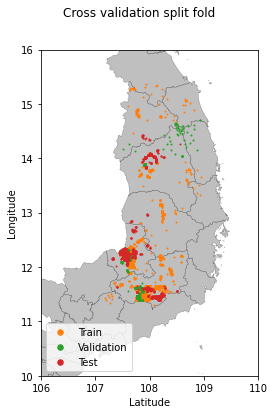

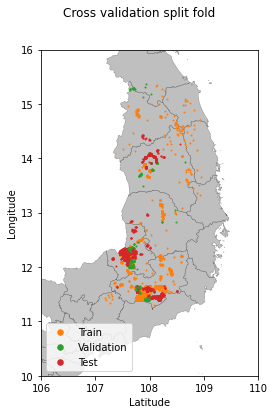

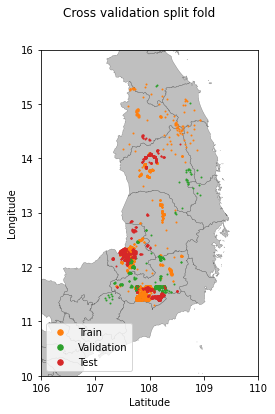

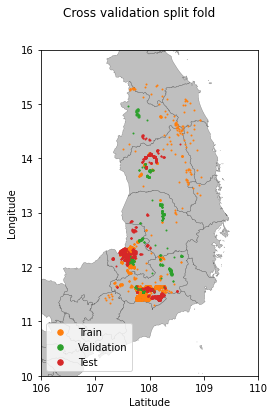

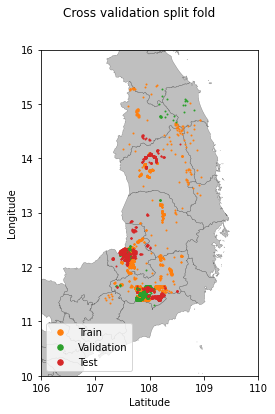

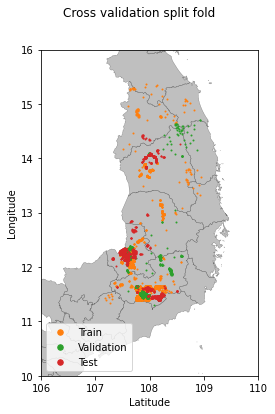

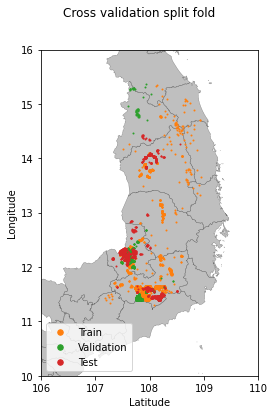

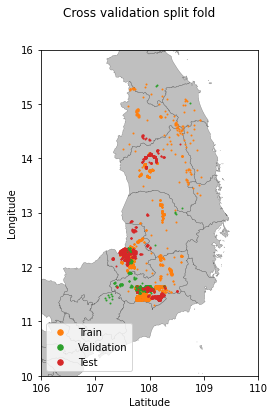

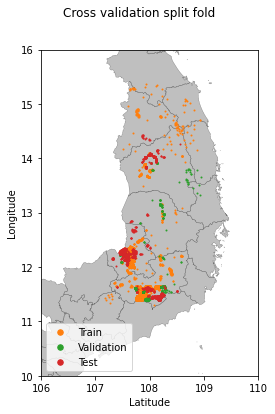

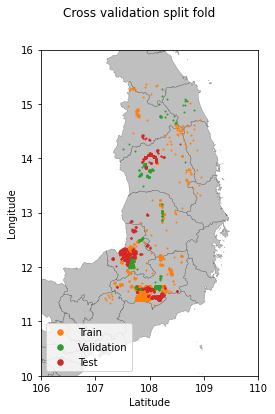

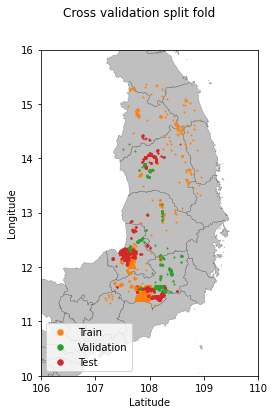

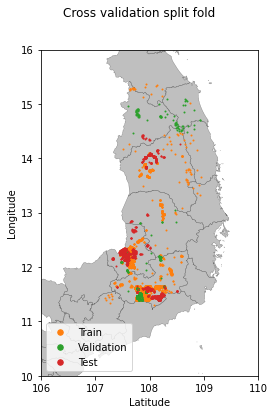

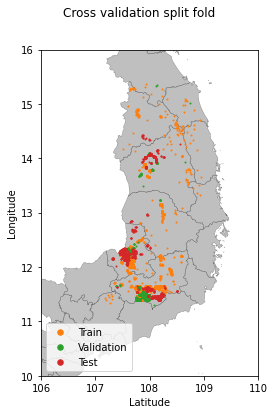

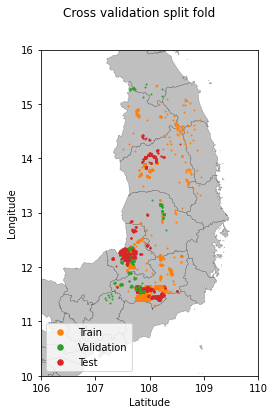

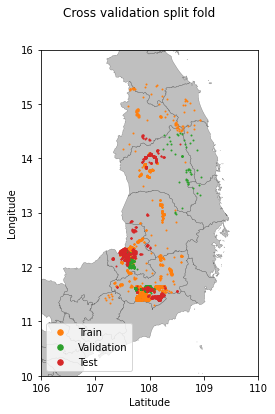

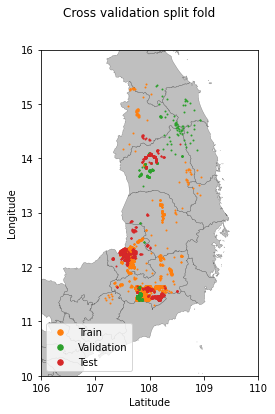

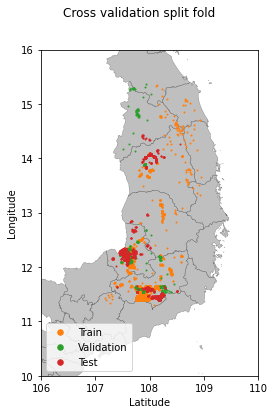

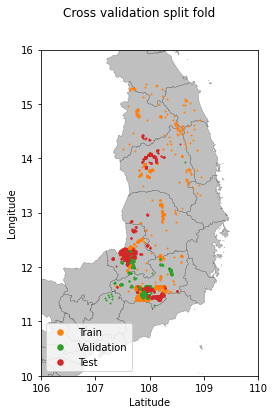

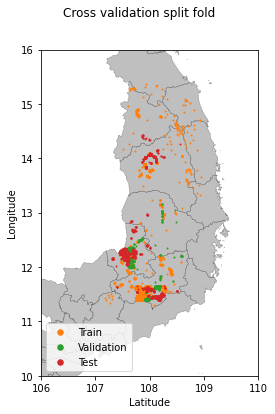

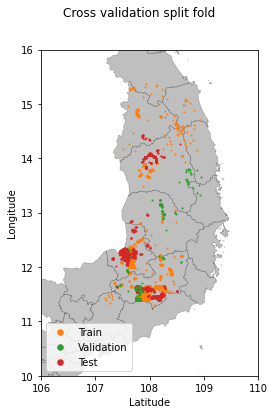

In [8]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation_from_csv_files(model, other_csv_filename, test_csv_filename, bands, labels, EPOCHS, NB_TESTS, early_stopping=True)

In [9]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  3.5933439416507333
mean accuracy:  1.7098572798394418


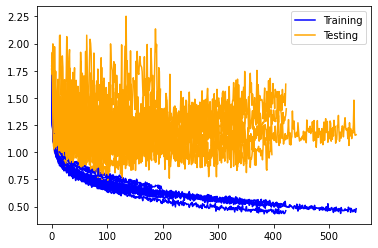

In [10]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

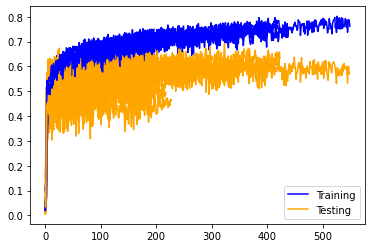

In [11]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

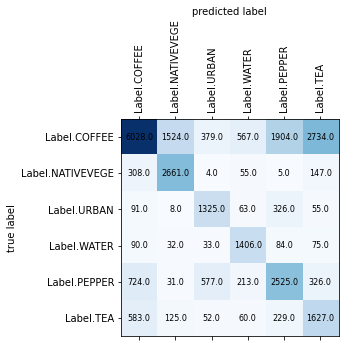

In [12]:
plot_confusion_matrix(conf_matrix, labels)

In [13]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.7704499  0.60739557 0.55907173 0.59475465 0.4977331  0.32775987]
Mean precision:  0.5595274700807492

Recalls:  [0.4588916  0.83679245 0.70931478 0.81744186 0.57438581 0.60799701]
Mean recall:  0.6674705833019852

F-Score:  [0.57519084 0.70387515 0.62529495 0.68854065 0.53331925 0.42591623]
Mean f-score:  0.5920228446702264
